In [1]:
#Importing the necessary packages

import tensorflow as tf
import os
import numpy as np
from matplotlib import pyplot as plt 
from skimage.io import imread, imshow
from skimage.transform import resize 
from tqdm import tqdm
import random

In [2]:
TRAIN_PATH = 'stage1_train/'
TEST_PATH = 'stage1_test/'

train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

In [3]:
#Defining the image dimensions 

IMG_WIDTH = 128 
IMG_HEIGHT = 128 
IMG_CHANNELS = 3 

X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype = np.uint8) 
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype = np.bool)


In [4]:
print('Resizing training images and masks')
# tqdm shows the progress bar during loop execution 
for n, id_ in tqdm(enumerate(train_ids), total = len(train_ids)):
    # Enter the path where the image is kept 
    path = TRAIN_PATH + id_
    # Read each image 
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    # Resize each image to (128, 128) size 
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode = 'constant', preserve_range = True)
    # Fill the empty array with values from the current image
    X_train[n] = img
    # Create a mask array 
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype = np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode = 'constant', preserve_range = True), axis = -1)
        # Taking the maximum pixel value for the mask
        mask = np.maximum(mask, mask_)
    Y_train[n] = mask
    

Resizing training images and masks


  0%|                                                                                          | 0/670 [00:00<?, ?it/s]C:\Users\admin\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
100%|████████████████████████████████████████████████████████████████████████████████| 670/670 [03:46<00:00,  6.12it/s]


In [5]:
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype = np.uint8)
sizes_test = []

print('Resizing test images')
for n, id_ in tqdm(enumerate(test_ids), total = len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode = 'constant', preserve_range = True)
    X_test[n] = img 
print('Done!')

Resizing test images


100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:06<00:00, 19.32it/s]


Done!


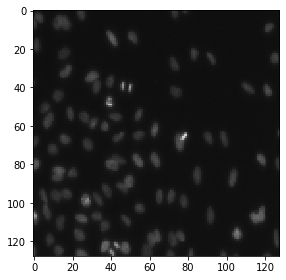

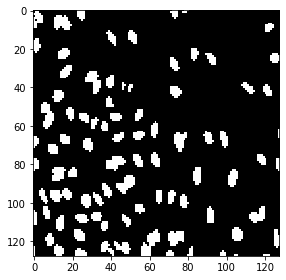

In [6]:
# Print the mask images 

# Pick a random number between 0-670
image_x = random.randint(0, len(train_ids))
imshow(X_train[image_x])
plt.show()
imshow(np.squeeze(Y_train[image_x]))
plt.show()

In [7]:
#Build the model(EXPANSION PATH)

# Step 1: Defining the input layer 
inputs = tf.keras.layers.Input((IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS))
# Step 2: Convert the integer values of the input to floating points 
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

#LAYER 1
# Step 3: Forming the first conv layer 
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(s)
# Step 4: Add dropout 
c1 = tf.keras.layers.Dropout(rate = 0.1)(c1)
# Step 5: Forming the second conv layer
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(c1)
# Step 6: Forming the max pool layer 
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

#LAYER 2
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(p1)
c2 = tf.keras.layers.Dropout(rate = 0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

#LAYER 3
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(p2)
c3 = tf.keras.layers.Dropout(rate = 0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

#LAYER 4
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(p3)
c4 = tf.keras.layers.Dropout(rate = 0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(c4)
p4 = tf.keras.layers.MaxPooling2D((2, 2))(c4)

#LAYER 5
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(p4)
c5 = tf.keras.layers.Dropout(rate = 0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(c5)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [8]:
#Build the Model(CONTRACTION PATH)

u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides = (2, 2), padding = 'same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(u6)
c6 = tf.keras.layers.Dropout(rate = 0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(c6)

u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides = (2, 2), padding = 'same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(u7)
c7 = tf.keras.layers.Dropout(rate = 0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(c7)

u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides = (2, 2), padding = 'same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(u8)
c8 = tf.keras.layers.Dropout(rate = 0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(c8)

u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides = (2, 2), padding = 'same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis = 3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(u9)
c9 = tf.keras.layers.Dropout(rate = 0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(c9)

In [9]:
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation = 'sigmoid')(c9)

model1 = tf.keras.Model(inputs = [inputs], outputs = [outputs])
model1.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
model1.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 128, 128, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 448         lambda[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 128, 128, 16) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (

__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, 128, 128, 16) 4624        concatenate_3[0][0]              
__________________________________________________________________________________________________
dropout_8 (Dropout)             (None, 128, 128, 16) 0           conv2d_16[0][0]                  
__________________________________________________________________________________________________
conv2d_17 (Conv2D)              (None, 128, 128, 16) 2320        dropout_8[0][0]                  
__________________________________________________________________________________________________
conv2d_18 (Conv2D)              (None, 128, 128, 1)  17          conv2d_17[0][0]                  
Total params: 1,941,105
Trainable params: 1,941,105
Non-trainable params: 0
__________________________________________________________________________________________________


In [10]:
# Adding a model checkpoint 

checkpointer = tf.keras.callbacks.ModelCheckpoint('model_new.h5', verbose = 1, save_best_only = True)

callback = [tf.keras.callbacks.EarlyStopping(patience = 2, monitor = 'val_loss'),
            tf.keras.callbacks.TensorBoard(histogram_freq = 0)]

results = model1.fit(X_train, Y_train, validation_split = 0.1, batch_size = 16, epochs = 25, callbacks = callback)


Train on 603 samples, validate on 67 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/25
603/603 [==============================] - ETA: 7:07 - loss: 11.6789 - acc: 0.24 - ETA: 3:56 - loss: 11.4383 - acc: 0.40 - ETA: 2:50 - loss: 11.2721 - acc: 0.49 - ETA: 2:16 - loss: 11.1082 - acc: 0.54 - ETA: 1:55 - loss: 11.3267 - acc: 0.59 - ETA: 1:41 - loss: 11.0355 - acc: 0.63 - ETA: 1:30 - loss: 10.8804 - acc: 0.66 - ETA: 1:22 - loss: 10.7963 - acc: 0.68 - ETA: 1:15 - loss: 10.7477 - acc: 0.70 - ETA: 1:10 - loss: 10.6818 - acc: 0.72 - ETA: 1:04 - loss: 10.6352 - acc: 0.73 - ETA: 1:00 - loss: 10.6084 - acc: 0.73 - ETA: 56s - loss: 10.5330 - acc: 0.7478 - ETA: 52s - loss: 10.4779 - acc: 0.752 - ETA: 49s - loss: 10.4054 - acc: 0.759 - ETA: 46s - loss: 10.2687 - acc: 0.766 - ETA: 43s - loss: 10.1366 - acc: 0.772 - ETA: 40s - loss: 10.0307 - acc: 0.776 - ETA: 37s - loss: 9.9605 - acc: 0.779 - ETA: 35s - loss: 9.8587 - acc: 0.78 - ETA: 32s - loss: 9.7777 - acc: 0.78 - ETA: 30s - loss: 

603/603 [==============================] - ETA: 53s - loss: 1.1881 - acc: 0.97 - ETA: 52s - loss: 1.3789 - acc: 0.96 - ETA: 50s - loss: 1.4340 - acc: 0.96 - ETA: 49s - loss: 1.5487 - acc: 0.96 - ETA: 47s - loss: 1.5936 - acc: 0.96 - ETA: 46s - loss: 1.5592 - acc: 0.96 - ETA: 44s - loss: 1.6148 - acc: 0.96 - ETA: 43s - loss: 1.6236 - acc: 0.96 - ETA: 41s - loss: 1.6777 - acc: 0.95 - ETA: 40s - loss: 1.7720 - acc: 0.95 - ETA: 38s - loss: 1.7819 - acc: 0.95 - ETA: 37s - loss: 1.8365 - acc: 0.95 - ETA: 35s - loss: 1.8227 - acc: 0.95 - ETA: 34s - loss: 1.7776 - acc: 0.95 - ETA: 32s - loss: 1.7682 - acc: 0.95 - ETA: 31s - loss: 1.7626 - acc: 0.95 - ETA: 30s - loss: 1.7699 - acc: 0.95 - ETA: 28s - loss: 1.8460 - acc: 0.95 - ETA: 27s - loss: 1.8452 - acc: 0.95 - ETA: 25s - loss: 1.8454 - acc: 0.95 - ETA: 24s - loss: 1.8531 - acc: 0.95 - ETA: 22s - loss: 1.8248 - acc: 0.95 - ETA: 21s - loss: 1.8318 - acc: 0.95 - ETA: 20s - loss: 1.8426 - acc: 0.95 - ETA: 18s - loss: 1.8399 - acc: 0.95 - ETA: 17

603/603 [==============================] - ETA: 53s - loss: 1.7130 - acc: 0.95 - ETA: 52s - loss: 1.3396 - acc: 0.96 - ETA: 50s - loss: 1.4142 - acc: 0.96 - ETA: 49s - loss: 1.4849 - acc: 0.96 - ETA: 47s - loss: 1.4437 - acc: 0.96 - ETA: 46s - loss: 1.3351 - acc: 0.96 - ETA: 44s - loss: 1.3228 - acc: 0.96 - ETA: 43s - loss: 1.3366 - acc: 0.96 - ETA: 41s - loss: 1.3684 - acc: 0.96 - ETA: 40s - loss: 1.3682 - acc: 0.96 - ETA: 38s - loss: 1.3844 - acc: 0.96 - ETA: 37s - loss: 1.4006 - acc: 0.96 - ETA: 36s - loss: 1.3779 - acc: 0.96 - ETA: 34s - loss: 1.3708 - acc: 0.96 - ETA: 33s - loss: 1.3631 - acc: 0.96 - ETA: 31s - loss: 1.3294 - acc: 0.96 - ETA: 30s - loss: 1.3211 - acc: 0.96 - ETA: 28s - loss: 1.3421 - acc: 0.96 - ETA: 27s - loss: 1.3543 - acc: 0.96 - ETA: 25s - loss: 1.3662 - acc: 0.96 - ETA: 24s - loss: 1.3780 - acc: 0.96 - ETA: 22s - loss: 1.3939 - acc: 0.96 - ETA: 21s - loss: 1.3924 - acc: 0.96 - ETA: 19s - loss: 1.3749 - acc: 0.96 - ETA: 18s - loss: 1.3780 - acc: 0.96 - ETA: 17

In [18]:
scores = model1.evaluate(X_train, Y_train, verbose=0)
print("The accuracy acheived is = %.2f" % (scores[1] * 100))

The accuracy acheived is = 97.03


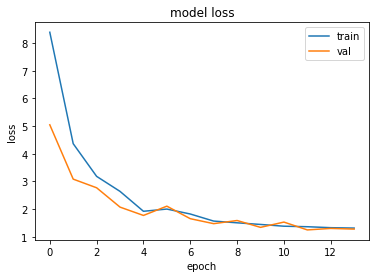

In [20]:
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [58]:
idx = random.randint(0, len(X_train))

In [59]:
predict_train = model1.predict(X_train[:int(X_train.shape[0] * 0.9)], verbose = 1)
predict_val = model1.predict(X_train[int(X_train.shape[0] * 0.9):], verbose = 1)
pred_test = model1.predict(X_test, verbose = 1)

65/65 [==============================] - ETA:  - ETA:  - 2s 33ms/sample


In [68]:
predict_train_t = (predict_train > 0.5).astype(np.uint8)
predict_val_t = (predict_val > 0.5).astype(np.uint8)
pred_test_t = (predict_val > 0.5).astype(np.uint8)

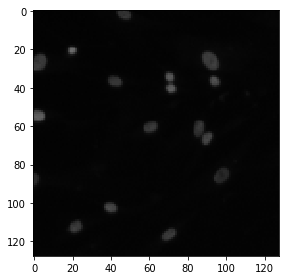

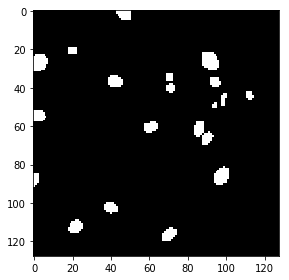

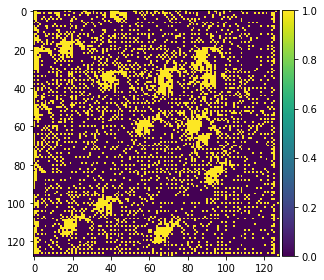

In [69]:
# Perform a sanity check on some random training samples 
ix = random.randint(0, len(predict_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(predict_train_t[ix]))
plt.show()